In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
data = pd.read_csv('/content/drive/MyDrive/microbiome data/vect_atlas.csv')
sample_id_data = pd.read_csv('/content/drive/MyDrive/microbiome data/sampleID.csv')
taxo_data = pd.read_csv('/content/drive/MyDrive/microbiome data/taxo.csv')


In [ ]:
# Check if 'Unnamed: 0' exists and set it as the index if it does
if 'Unnamed: 0' in data.columns:
    data.set_index('Unnamed: 0', inplace=True)
if 'Unnamed: 0' in taxo_data.columns:
    taxo_data.set_index('Unnamed: 0', inplace=True)

In [ ]:
# Filter the sample information for T2D and Control groups
t2d_samples = sample_id_data[sample_id_data['Disease'] == 'T2D']['sample.ID']
control_samples = sample_id_data[sample_id_data['Disease'] == 'Healthy']['sample.ID']


In [ ]:
# Filter and merge the main dataset with taxonomy for T2D and Control
control_data_filtered = data[control_samples.tolist()]
t2d_data_filtered = data[t2d_samples.tolist()]

control_merged_data = control_data_filtered.merge(taxo_data[['class', 'phylum']], left_index=True, right_index=True)
t2d_merged_data = t2d_data_filtered.merge(taxo_data[['class', 'phylum']], left_index=True, right_index=True)

# Aggregate data at the class level by summing only numeric columns
control_class_abundance = control_merged_data.select_dtypes(include=[float, int]).groupby(control_merged_data['class']).sum().sum(axis=1).sort_values(ascending=False)
t2d_class_abundance = t2d_merged_data.select_dtypes(include=[float, int]).groupby(t2d_merged_data['class']).sum().sum(axis=1).sort_values(ascending=False)


# Convert to relative abundance
control_class_relative_abundance = (control_class_abundance / control_class_abundance.sum()) * 100
t2d_class_relative_abundance = (t2d_class_abundance / t2d_class_abundance.sum()) * 100


In [ ]:
# Combine into a DataFrame for plotting
class_data = pd.DataFrame({
    'Control': control_class_relative_abundance,
    'T2D': t2d_class_relative_abundance
}).fillna(0)

In [ ]:
stacked_class_data = class_data.T

<Figure size 800x800 with 0 Axes>

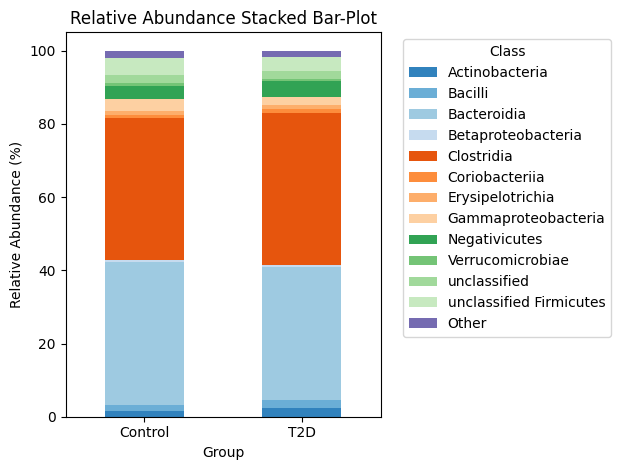

In [ ]:
# Re-aggregate small values manually without modifying the DataFrame in-place
def aggregate_small_values_for_plot(data, threshold=0.5):
    aggregated_data = data.copy()
    other = pd.Series(0, index=data.columns)

    for class_name in data.index:
        small_class = data.loc[class_name] < threshold
        if small_class.any():  # If any class values are below threshold
            other += data.loc[class_name, small_class]
            aggregated_data.drop(class_name, inplace=True)

    aggregated_data.loc['Other'] = other
    return aggregated_data

# Applying the function to aggregate small class values into 'Other'
adjusted_class_data_plot = aggregate_small_values_for_plot(class_data)

# Transpose the data for stacked plotting
adjusted_stacked_class_data_plot = adjusted_class_data_plot.T

# Plotting the adjusted stacked bar chart
plt.figure(figsize=(8, 8))
adjusted_stacked_class_data_plot.plot(kind='bar', stacked=True, color=plt.cm.tab20c.colors)
plt.title('Relative Abundance Stacked Bar-Plot')
plt.xlabel('Group')
plt.ylabel('Relative Abundance (%)')
plt.xticks(rotation=0)
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# PCA # Combine T2D and Control data for PCA
combined_data = pd.concat([control_data_filtered, t2d_data_filtered], axis=1)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(combined_data.T)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Group'] = ['Control'] * len(control_samples) + ['T2D'] * len(t2d_samples)

# Plotting
plt.figure(figsize=(10, 6))
for label, color in zip(pca_df['Group'].unique(), ['blue', 'red']):
    condition = pca_df['Group'] == label
    plt.scatter(pca_df.loc[condition, 'PC1'], pca_df.loc[condition, 'PC2'], c=color, label=label)
plt.title('PCA of T2D and Control Samples')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()